In [20]:
from astropy.io import fits
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import os
import subprocess
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage
import keras
from keras.models import load_model
from __future__ import print_function

In [21]:
gpu_code_path = "../code/gpu/"
real_image_name = "chip_1"
real_image_path = gpu_code_path+"images/"+real_image_name
psi_image_path = gpu_code_path+"output-images/psi"
phi_image_path = gpu_code_path+"output-images/phi"

In [22]:
def execute(cmd):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line 
    popen.stdout.close()
    return_code = popen.wait()
    if return_code:
        raise subprocess.CalledProcessError(return_code, cmd)

In [23]:
paramsFile = open('../code/gpu/debug/parameters.config', 'w')
paramsFile.write(
"""Debug ................ : 1
Image Count .......... : 15
Generate Images ...... : 0
Image Width .......... : 100
Image Height ......... : 100
PSF Sigma ............ : 1.0
Object Brightness .... : 50.0
Object Initial x ..... : 50.0
Object Initial y ..... : 58.0
Velocity x ........... : -1.33
Velocity y ........... : -0.2
Background Level ..... : 1024.0
Background Sigma ..... : 4.0
Mask Threshold ....... : 0.75
Mask Penalty ......... : -0.05
Angles to Search ..... : 120
Minimum Angle ........ : 0.0
Maximum Angle ........ : 6.283
Velocities to Search . : 20
Minimum Velocity ..... : 300
Maximum Velocity ..... : 450
Psi/Phi to file ...... : 1
Source Images Path ... : ../../{source}/
Psi Images Path ...... : ../../{psi}/
Phi Images Path....... : ../../{phi}/
""".format( source=real_image_path, psi=psi_image_path, phi=phi_image_path ))
paramsFile.close()

In [24]:
popen = subprocess.Popen( "./clearImages.sh", stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE)
popen.wait()
output = popen.stderr.read()
output += popen.stdout.read()
print( output)

In [25]:
for path in execute("./search.sh"):
    print(path, end="")

Image Count ..........  : 15
Generate Images ......  : 0
Image Width ..........  : 100
Image Height .........  : 100
PSF Sigma ............  : 1.0
Object Brightness ....  : 50.0
Object Initial x .....  : 50.0
Object Initial y .....  : 58.0
Velocity x ...........  : -1.33
Velocity y ...........  : -0.2
Background Level .....  : 1024.0
Background Sigma .....  : 4.0
Mask Threshold .......  : 0.75
Mask Penalty .........  : -0.05
Angles to Search .....  : 120
Minimum Angle ........  : 0.0
Maximum Angle ........  : 6.283
Velocities to Search .  : 20
Minimum Velocity .....  : 300
Maximum Velocity .....  : 450
Psi/Phi to file ......  : 1
Source Images Path ...  : ../../../code/gpu/images/chip_1/
Psi Images Path ......  : ../../../code/gpu/output-images/psi/
Phi Images Path.......  : ../../../code/gpu/output-images/phi/
Using Kernel Size 5X5
| 0.004 | 0.015 | 0.023 | 0.015 | 0.004 | 
 ---------------------------------------
| 0.015 | 0.058 | 0.093 | 0.058 | 0.015 | 
 ---------------------------

In [26]:
raw_results = np.genfromtxt('../code/gpu/debug/results/results.txt', names=True)

In [27]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
#image_times*=24.

Load Psi Images

In [28]:
hdulist = fits.open(os.path.join(psi_image_path, os.listdir(psi_image_path)[0]))
num_images = len(os.listdir(psi_image_path))
image_shape = np.shape(hdulist[0].data)
im_psi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(psi_image_path)))):

    #print (str('Loaded ' + filename))

    image_file = os.path.join(psi_image_path, filename)
    hdulist = fits.open(image_file)
    im_psi_array[idx] = hdulist[0].data#*mask


Load Phi Images (for potentially making psi/phi stamps)

In [29]:
hdulist = fits.open(os.path.join(phi_image_path, os.listdir(phi_image_path)[0]))
num_images = len(os.listdir(phi_image_path))
image_shape = np.shape(hdulist[0].data)
im_phi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(phi_image_path)))):

   # print (str('Loaded ' + filename))

    image_file = os.path.join(phi_image_path, filename)
    hdulist = fits.open(image_file)
    im_phi_array[idx] = hdulist[0].data#*mask


In [30]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

   # print( str('Loaded ' + filename))

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


In [31]:
ai = analyzeImage()

In [32]:
model = load_model('../data/kbmod_model.h5')

In [39]:
results = raw_results[0:420000]
#results = results[np.where((results['t0_x'] > 1100) & (results['t0_x'] < 1200) & 
#                           (results['t0_y'] > 3000) & (results['t0_y'] < 3100) )]
results


array([(1348.0, 1342.0, 0.0, 0.0, 0.02, 427.5, 6875.877, 460.098),
       (1348.0, 1341.0, 0.0, 0.0, 0.021, 442.5, 6867.137, 459.854),
       (1348.0, 1343.0, 0.0, 0.0, 0.02, 427.5, 6865.485, 452.201), ...,
       (1097.0, 428.0, 0.0, 0.0, -19.216, 366.997, 23.063, 3.744),
       (1512.0, 645.0, 0.0, 0.0, -0.06, -427.5, 23.063, 3.738),
       (1908.0, 888.0, 0.0, 0.0, 179.92, -404.271, 23.064, 3.787)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [34]:
#filtered_results = ai.filter_results(im_array, results, image_times, model, chunk_size=1000)

In [35]:
#print( len(filtered_results) )
#filtered_results

In [40]:
results_to_cluster = results#filtered_results
arg = dict(eps=0.015, min_samples=1, n_jobs=-1)
clustered_results = ai.clusterResults(results_to_cluster, dbscan_args=arg)#, im_array, image_times)
clustered_results =  results_to_cluster[np.array(clustered_results[1], dtype=np.int)]
#best_targets = range(stamp_count)
#best_targets

In [41]:
print( len(clustered_results) )
clustered_results[0:80]

117


array([(1348.0, 1342.0, 0.0, 0.0, 0.02, 427.5, 6875.877, 460.098),
       (1136.0, 3088.0, 0.0, 0.0, 315.085, 120.946, 197.853, 31.74),
       (1700.0, 3980.0, 0.0, 0.0, 294.079, 112.883, 100.592, 16.131),
       (1838.0, 1942.0, 0.0, 0.0, 404.213, -180.051, 72.111, 11.69),
       (1935.0, 3093.0, 0.0, 0.0, -67.035, 315.456, 55.579, 8.888),
       (1617.0, 2407.0, 0.0, 0.0, -242.725, -176.309, 53.015, 8.482),
       (1699.0, 1522.0, 0.0, 0.0, 46.943, 296.305, 52.75, 8.483),
       (564.0, 2908.0, 0.0, 0.0, -222.764, -222.713, 50.359, 7.928),
       (916.0, 544.0, 0.0, 0.0, -228.541, -205.732, 49.981, 7.936),
       (1786.0, 2620.0, 0.0, 0.0, -293.45, -62.345, 49.925, 7.756),
       (628.0, 3669.0, 0.0, 0.0, 268.12, 217.11, 49.5, 7.523),
       (1756.0, 1229.0, 0.0, 0.0, -285.326, -92.676, 48.911, 7.759),
       (736.0, 1186.0, 0.0, 0.0, -296.311, -46.901, 47.026, 7.378),
       (113.0, 2736.0, 0.0, 0.0, 136.206, 267.298, 46.436, 7.193),
       (1728.0, 2842.0, 0.0, 0.0, -193.544, -238.

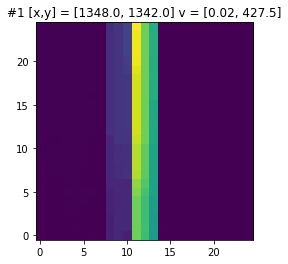

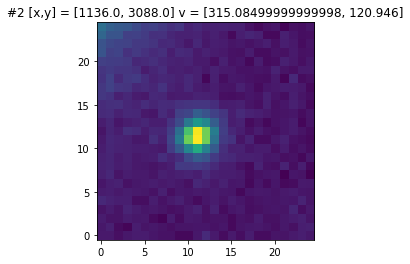

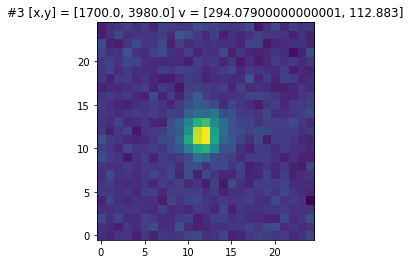

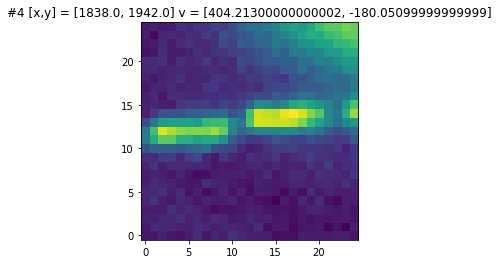

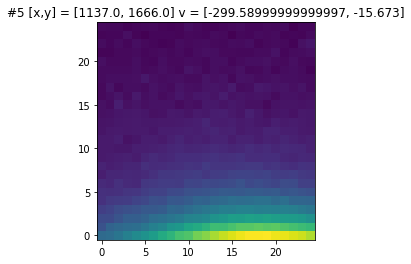

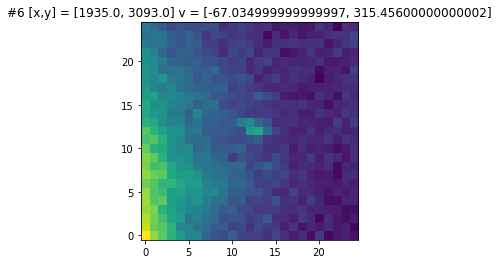

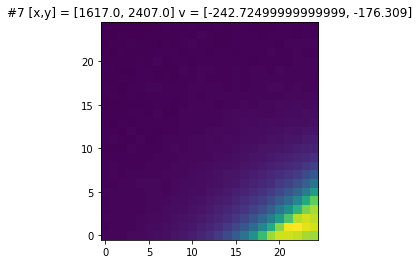

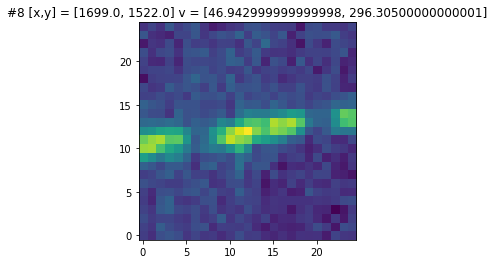

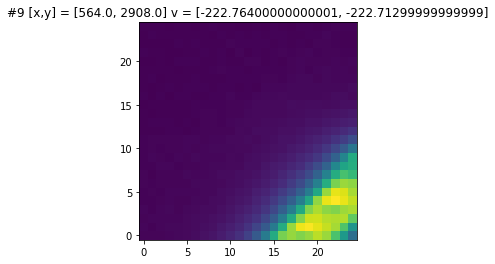

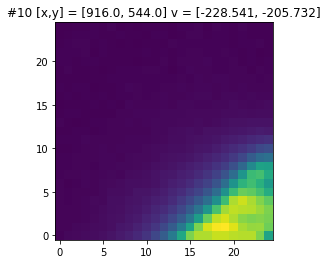

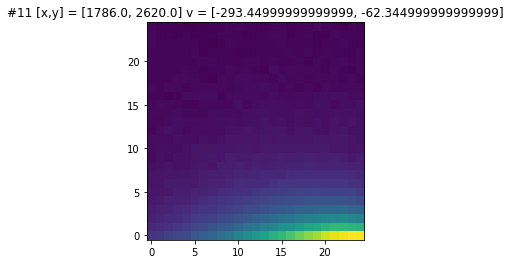

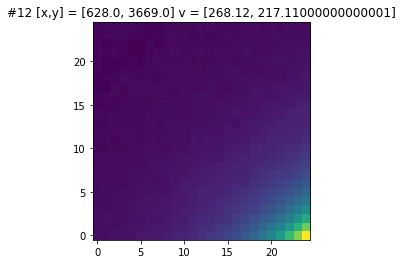

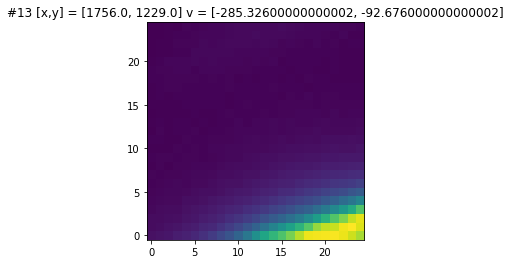

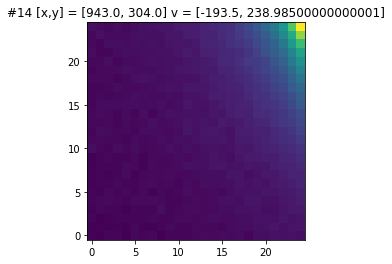

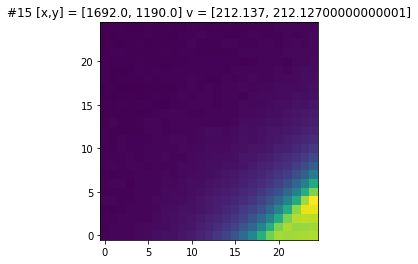

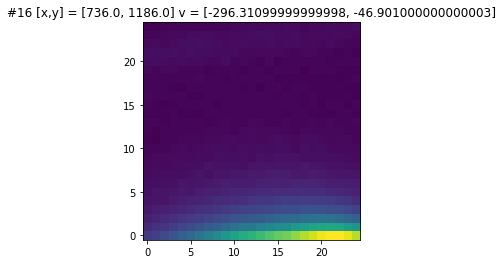

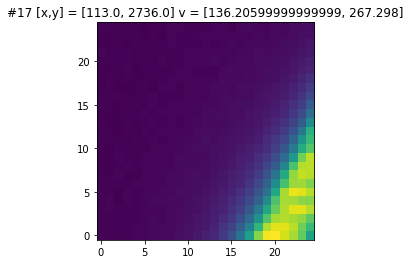

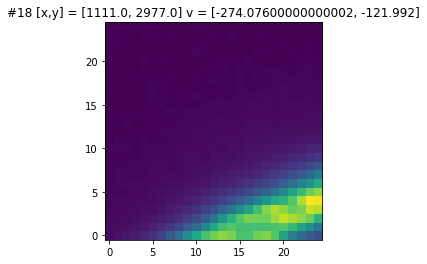

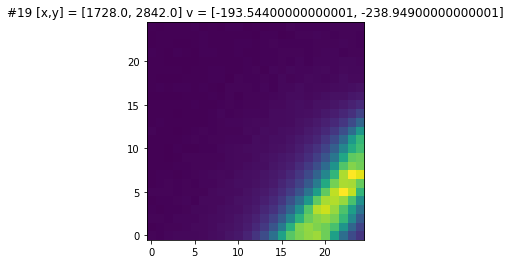

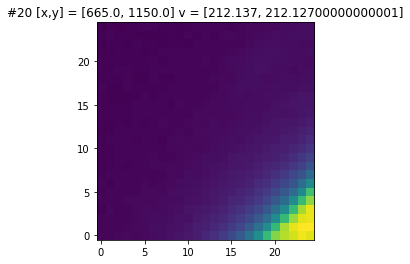

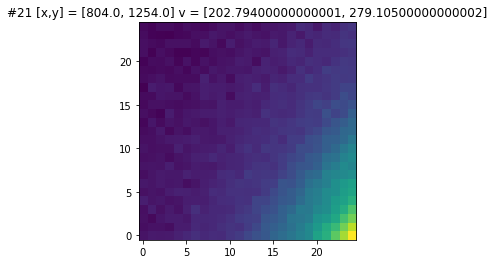

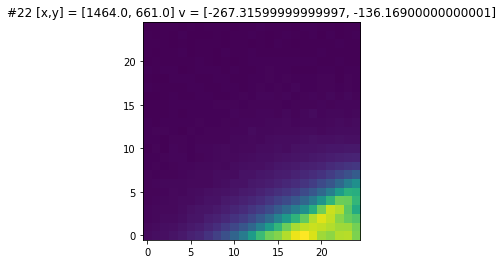

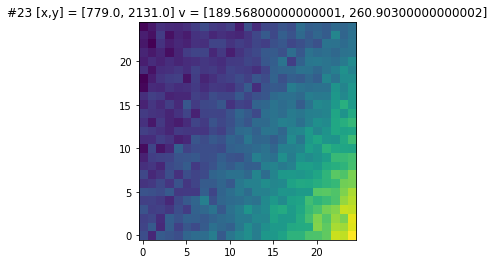

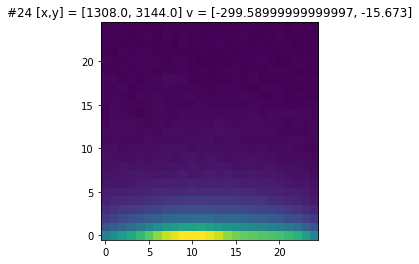

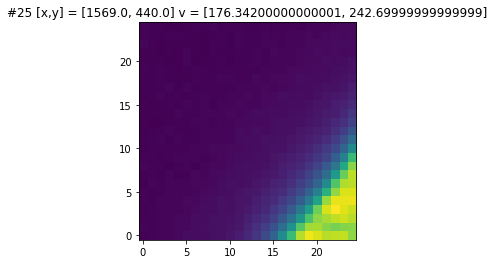

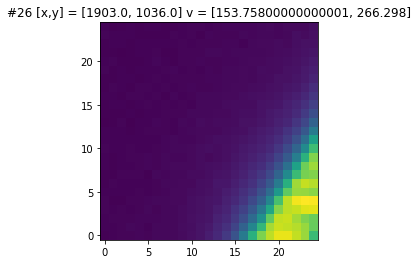

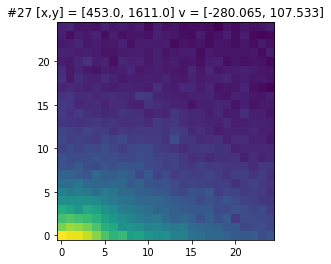

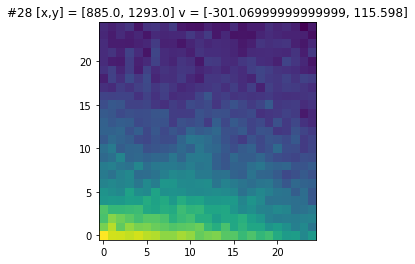

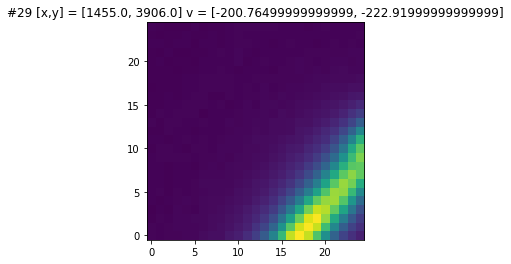

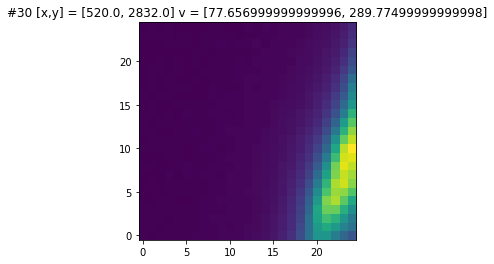

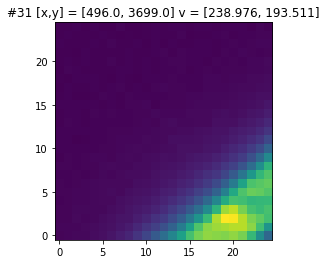

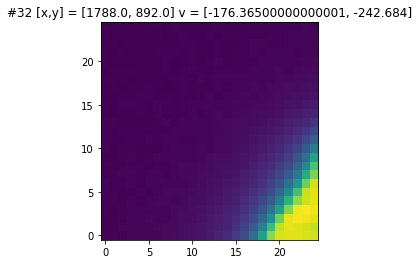

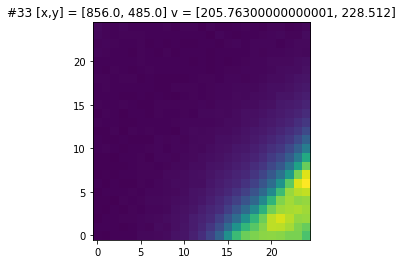

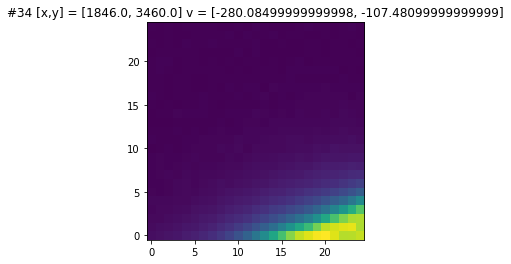

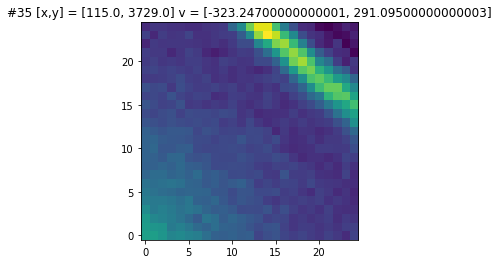

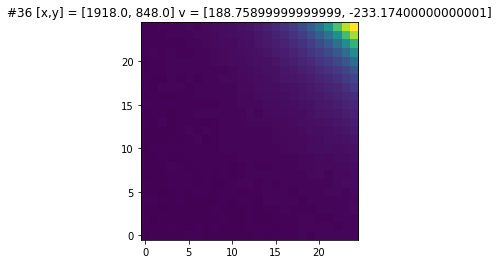

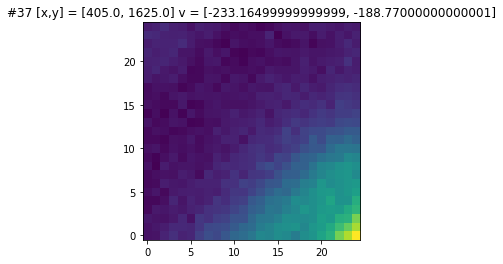

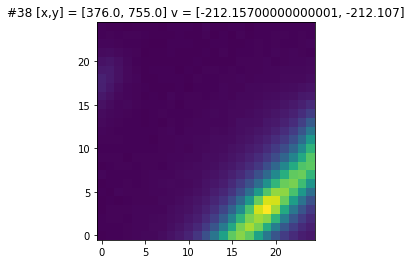

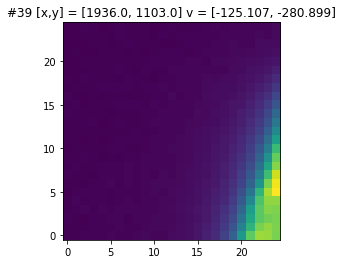

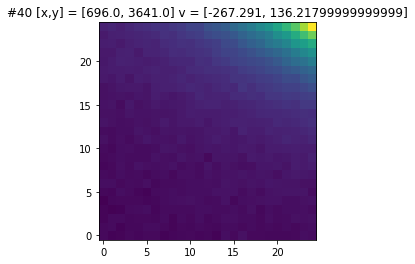

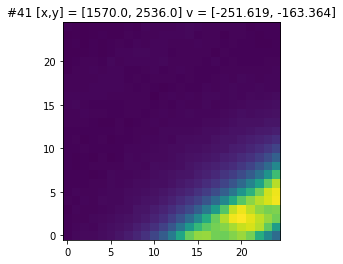

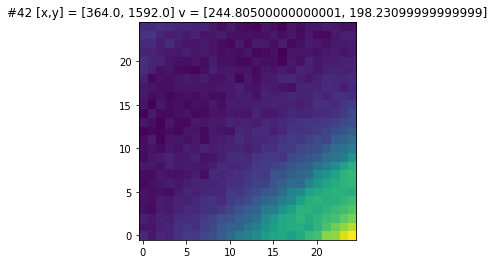

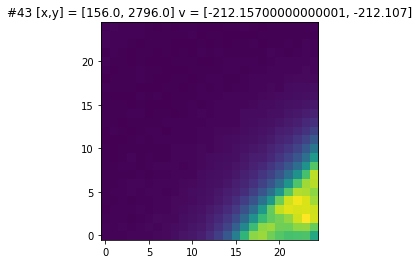

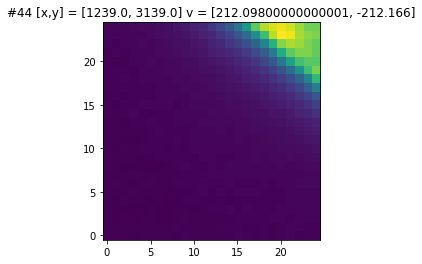

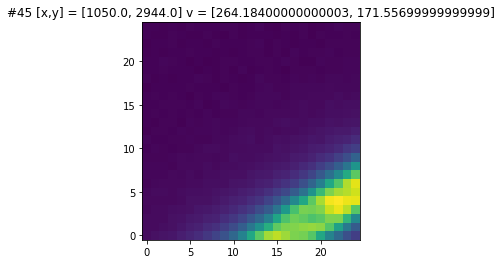

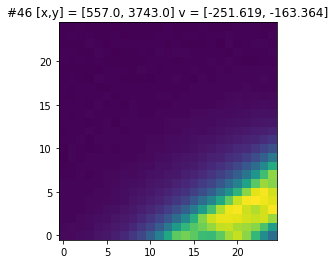

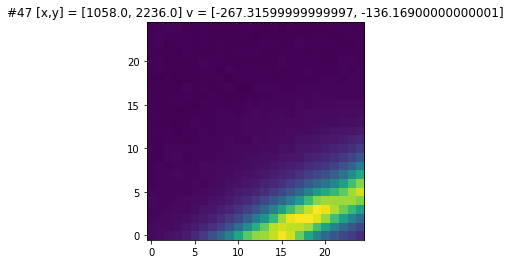

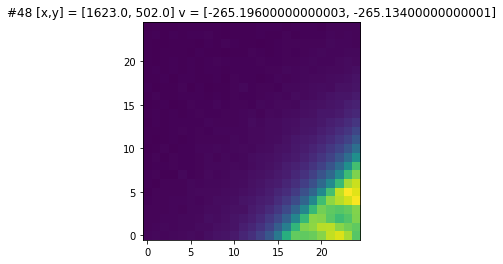

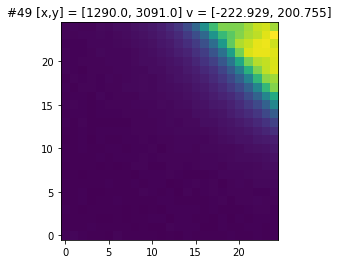

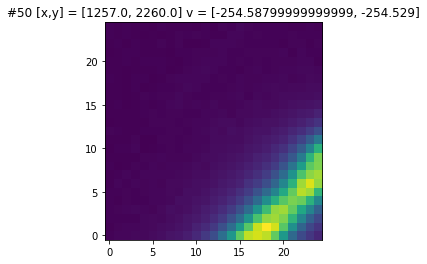

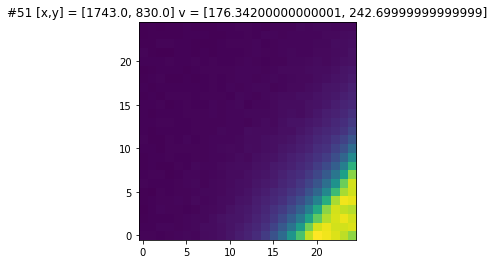

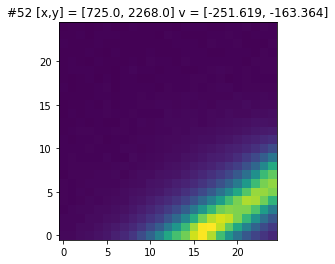

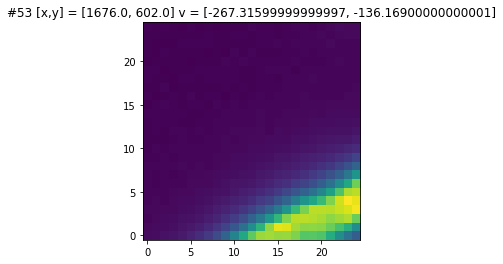

In [38]:
create_files = False
maxshow = 2500 if create_files else 75
f_results = clustered_results#results if create_files else clustered_results #filtered_results
imgs = im_array
for imNum in range(min(len(f_results), maxshow)):
    cr = f_results[imNum]
    if create_files:
        arr = ai.createPostageStamp(imgs,
            list(f_results[['t0_x', 't0_y']][imNum]),
            np.array(list(f_results[['v_x', 'v_y']][imNum])),
            image_times, [25., 25.])[0]
        arr -= arr.min()
        arr *= (255.0/arr.max())
        im = Image.fromarray(arr.astype(np.uint8))
        im.save("../data/stamps/c"+real_image_name[-1]+
            "p"+str(int(cr[0]))+"_"+str(int(cr[1]))+
            "v"+str(int(cr[4]))+"_"+str(int(cr[5]))+".tif")
        #plt.savefig("../data/stamps/c"+real_image_name[-1]+
        #         "p"+str(int(cr[0]))+"_"+str(int(cr[1]))+
        #         "v"+str(int(cr[4]))+"_"+str(int(cr[5]))+".png")
    else:
        plt.imshow(ai.createPostageStamp(imgs,
            list(f_results[['t0_x', 't0_y']][imNum]),
            np.array(list(f_results[['v_x', 'v_y']][imNum])),
            image_times, [25., 25.])[0],
            origin='lower',
            #cmap=plt.cm.Greys_r,
            interpolation='None')
        plt.title(str('#' + str(imNum+1) + ' [x,y] = '
                + str(list(f_results[['t0_x', 't0_y']][imNum])))
                  + ' v = ' + str(list(f_results[['v_x', 'v_y']][imNum])))
        plt.show()
    
